# Linear Regression Algorithms using Apache SystemML

This notebook shows:
- Install SystemML Python package and jar file
  - pip
  - SystemML 'Hello World'
- Example 1: Matrix Multiplication
  - SystemML script to generate a random matrix, perform matrix multiplication, and compute the sum of the output
  - Examine execution plans, and increase data size to obverve changed execution plans
- Load diabetes dataset from scikit-learn
- Example 2: Implement three different algorithms to train linear regression model
  - Algorithm 1: Linear Regression - Direct Solve (no regularization)
  - Algorithm 2: Linear Regression - Batch Gradient Descent (no regularization)
  - Algorithm 3: Linear Regression - Conjugate Gradient (no regularization)
- Example 3: Invoke existing SystemML algorithm script LinearRegDS.dml using MLContext API
- Example 4: Invoke existing SystemML algorithm using scikit-learn/SparkML pipeline like API
- Uninstall/Clean up SystemML Python package and jar file

# Install SystemML Python package and jar file

In [1]:
!pip uninstall systemml --y
#!pip install --user https://repository.apache.org/content/groups/snapshots/org/apache/systemml/systemml/1.0.0-SNAPSHOT/systemml-1.0.0-20171201.070207-23-python.tar.gz
!pip install systemml

Uninstalling systemml-1.2.0:
  Successfully uninstalled systemml-1.2.0
You are using pip version 19.0.3, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
!pip show systemml

Name: systemml
Version: 1.2.0
Summary: Apache SystemML is a distributed and declarative machine learning platform.
Home-page: http://systemml.apache.org/
Author: Apache SystemML
Author-email: dev@systemml.apache.org
License: Apache 2.0
Location: /Users/nilmeier@us.ibm.com/anaconda2/envs/py35/lib/python3.5/site-packages
Requires: pandas, scikit-learn, Pillow, numpy, scipy
Required-by: 


### Import SystemML API 

In [2]:
from pyspark import SparkContext
from systemml import MLContext, dml, dmlFromResource
sc = SparkContext("local", "Simple App")
ml = MLContext(sc)

print("Spark Version:", sc.version) 
print("SystemML Version:", ml.version()) 
print("SystemML Built-Time:", ml.buildTime()) 

Spark Version: 2.2.1
SystemML Version: 1.2.0
SystemML Built-Time: 2018-08-17 05:58:31 UTC


In [4]:
ml.execute(dml("""s = 'Hello World!'""").output("s")).get("s")

SystemML Statistics:
Total execution time:		0.001 sec.
Number of executed Spark inst:	0.




'Hello World!'

### Import numpy, sklearn, and define some helper functions

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
plt.switch_backend('agg')

# Example 1: Matrix Multiplication

### SystemML script to generate a random matrix, perform matrix multiplication, and compute the sum of the output

In [6]:
script = """
    X = rand(rows=$nr, cols=1000, sparsity=0.5)
    A = t(X) %*% X
    s = sum(A)
"""

In [4]:
prog = dml(script).input('$nr', 1e5).output('s')
s = ml.execute(prog).get('s')
print (s)

NameError: name 'script' is not defined

# Load diabetes dataset from scikit-learn 

In [ ]:
%matplotlib inline

In [ ]:
diabetes = datasets.load_diabetes()
diabetes_X = diabetes.data[:, np.newaxis, 2]
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
diabetes_y_train = diabetes.target[:-20].reshape(-1,1)
diabetes_y_test = diabetes.target[-20:].reshape(-1,1)

plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

In [ ]:
diabetes.data.shape

# Example 2: Implement three different algorithms to train linear regression model

## Algorithm 1: Linear Regression - Direct Solve (no regularization) 

#### Least squares formulation
w* = argminw ||Xw-y||2 = argminw (y - Xw)'(y - Xw) = argminw (w'(X'X)w - w'(X'y))/2

#### Setting the gradient
dw = (X'X)w - (X'y) to 0, w = (X'X)-1(X' y) = solve(X'X, X'y)

In [ ]:
script = """
    # add constant feature to X to model intercept
    X = cbind(X, matrix(1, rows=nrow(X), cols=1))
    A = t(X) %*% X
    b = t(X) %*% y
    w = solve(A, b)
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]
"""

In [ ]:
prog = dml(script).input(X=diabetes_X_train, y=diabetes_y_train).output('w', 'bias')
w, bias = ml.execute(prog).get('w','bias')
w = w.toNumPy()

In [ ]:
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w*diabetes_X_test)+bias, color='blue', linestyle ='dotted')

## Algorithm 2: Linear Regression - Batch Gradient Descent (no regularization)

#### Algorithm
`Step 1: Start with an initial point 
while(not converged) { 
  Step 2: Compute gradient dw. 
  Step 3: Compute stepsize alpha.     
  Step 4: Update: wnew = wold + alpha*dw 
}`

#### Gradient formula
`dw = r = (X'X)w - (X'y)`

#### Step size formula
`Find number alpha to minimize f(w + alpha*r) 
alpha = -(r'r)/(r'X'Xr)`

![Gradient Descent](http://blog.datumbox.com/wp-content/uploads/2013/10/gradient-descent.png)

In [14]:
script = """
    # add constant feature to X to model intercepts
    X = cbind(X, matrix(1, rows=nrow(X), cols=1))
    max_iter = 100
    w = matrix(0, rows=ncol(X), cols=1)
    for(i in 1:max_iter){
        XtX = t(X) %*% X
        dw = XtX %*%w - t(X) %*% y
        alpha = -(t(dw) %*% dw) / (t(dw) %*% XtX %*% dw)
        w = w + dw*alpha
    }
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]    
"""

In [15]:
prog = dml(script).input(X=diabetes_X_train, y=diabetes_y_train).output('w', 'bias')
w, bias = ml.execute(prog).get('w', 'bias')
w = w.toNumPy()

SystemML Statistics:
Total execution time:		0.073 sec.
Number of executed Spark inst:	2.




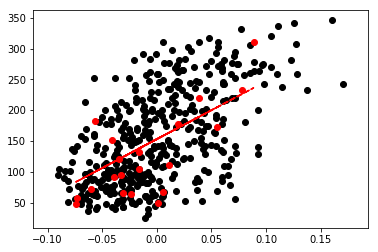

In [16]:
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w*diabetes_X_test)+bias, color='red', linestyle ='dashed')

# Algorithm 3: Linear Regression - Conjugate Gradient (no regularization)

Problem with gradient descent: Takes very similar directions many times

Solution: Enforce conjugacy

`Step 1: Start with an initial point 
while(not converged) {
   Step 2: Compute gradient dw.
   Step 3: Compute stepsize alpha.
   Step 4: Compute next direction p by enforcing conjugacy with previous direction.
   Step 4: Update: w_new = w_old + alpha*p
}`

![Gradient Descent vs Conjugate Gradient](http://i.stack.imgur.com/zh1HH.png)


In [17]:
script = """
    # add constant feature to X to model intercepts
    X = cbind(X, matrix(1, rows=nrow(X), cols=1))
    m = ncol(X); i = 1; 
    max_iter = 20;
    w = matrix (0, rows = m, cols = 1); # initialize weights to 0
    dw = - t(X) %*% y; p = - dw;        # dw = (X'X)w - (X'y)
    norm_r2 = sum (dw ^ 2); 
    for(i in 1:max_iter) {
        q = t(X) %*% (X %*% p)
        alpha = norm_r2 / sum (p * q);  # Minimizes f(w - alpha*r)
        w = w + alpha * p;              # update weights
        dw = dw + alpha * q;           
        old_norm_r2 = norm_r2; norm_r2 = sum (dw ^ 2);
        p = -dw + (norm_r2 / old_norm_r2) * p; # next direction - conjugacy to previous direction
        i = i + 1;
    }
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]    
"""

In [18]:
prog = dml(script).input(X=diabetes_X_train, y=diabetes_y_train).output('w', 'bias')
w, bias = ml.execute(prog).get('w','bias')
w = w.toNumPy()

SystemML Statistics:
Total execution time:		0.019 sec.
Number of executed Spark inst:	2.




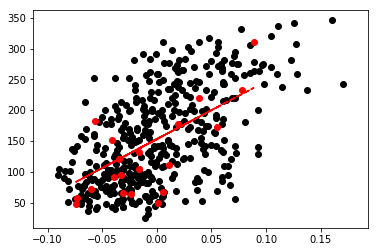

In [19]:
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w*diabetes_X_test)+bias, color='red', linestyle ='dashed')

# Example 3: Invoke existing SystemML algorithm script LinearRegDS.dml using MLContext API

In [20]:
prog = dmlFromResource('scripts/algorithms/LinearRegDS.dml').input(X=diabetes_X_train, y=diabetes_y_train).input('$icpt',1.0).output('beta_out')
w = ml.execute(prog).get('beta_out')
w = w.toNumPy()
bias=w[1]

BEGIN LINEAR REGRESSION SCRIPT
Reading X and Y...
Calling the Direct Solver...
Computing the statistics...
AVG_TOT_Y,153.36255924170615
STDEV_TOT_Y,77.21853383600028
AVG_RES_Y,3.633533705616816E-14
STDEV_RES_Y,63.038506337610244
DISPERSION,3973.853281276927
R2,0.3351312506863875
ADJUSTED_R2,0.33354822985468835
R2_NOBIAS,0.3351312506863875
ADJUSTED_R2_NOBIAS,0.33354822985468835
Writing the output matrix...
END LINEAR REGRESSION SCRIPT
SystemML Statistics:
Total execution time:		0.003 sec.
Number of executed Spark inst:	2.




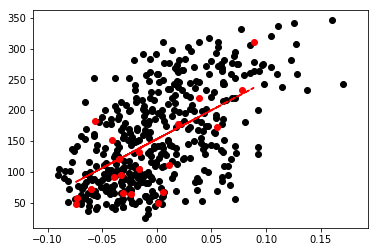

In [21]:
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w[0]*diabetes_X_test)+bias, color='red', linestyle ='dashed')

# Uninstall/Clean up SystemML Python package and jar file